In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\kolli\OneDrive\Documents\kaggle\test.csv")
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
# Extract titles using regex
df['Name'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Optional: Group rare titles under 'Rare'
df['Name'] = df['Name'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 
                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

# Optional: Normalize some variations
df['Name'] = df['Name'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

In [4]:
df.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [6]:
# Fill missing Age with median (Age is numeric and has outliers)
df['Age']= df['Age'].fillna(df['Age'].median())

# Fill missing Embarked with mode (most frequent)
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Create a new binary feature: HasCabin (1 = yes, 0 = no)
df['HasCabin'] = df['Cabin'].notnull().astype(int)

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
def treat_outliers_iqr(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    df[col] = np.where(df[col] > upper_bound, upper_bound,
                       np.where(df[col] < lower_bound, lower_bound, df[col]))

# Apply only to continuous features
for col in ['Age', 'Fare']:
    treat_outliers_iqr(col)

In [9]:
df.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin
0,3,male,34.500,0,0,7.8292,Q,0
1,3,female,47.000,1,0,7.0000,S,0
2,2,male,54.875,0,0,9.6875,Q,0
3,3,male,27.000,0,0,8.6625,S,0
4,3,female,22.000,1,1,12.2875,S,0


In [10]:
# Create 'FamilySize' from SibSp and Parch
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [11]:
# Create 'IsAlone' feature
df['IsAlone'] = 1  # Initialize to alone
df['IsAlone'].loc[df['FamilySize'] > 1] = 0  # If with family, not alone

C:\Users\kolli\AppData\Local\Temp\ipykernel_17888\171491984.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['IsAlone'].loc[df['FamilySize'] > 1] = 0  # If with family, not alone
C:\Users\kolli\AppData\Local\Temp\ipykernel_17888\171491

In [12]:
# Drop SibSp and Parch as they’re represented in FamilySize
df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [13]:
df['Fare_log'] = np.log1p(df['Fare'])  # log(1 + Fare) to avoid log(0)
df['Fare_log'].skew()

np.float64(0.23465267908347934)

In [14]:
from scipy.special import boxcox1p
import joblib

# Load parameters saved from training
params = joblib.load('boxcox_params.pkl')
fare_lambda = params['fare_lambda']
shift = params['shift']

# Shift test data
df['Fare_shifted'] = df['Fare'] + shift

# Apply boxcox transformation using loaded lambda
df['Fare_boxcox'] = boxcox1p(df['Fare_shifted'], fare_lambda)


In [15]:
df['Fare_sqr'] = df['Fare'] * (1/4)
df['Fare_sqr'].skew()

np.float64(1.0867409150190164)

In [16]:
df['Age_log'] = np.sqrt(df['Age'])
df['Age_log'].skew()

np.float64(-0.40484147323313724)

In [17]:
df['Age_sqr'] = df['Age'] * (1/4)
df['Age_sqr'].skew()

np.float64(0.45376898640293223)

In [18]:
from scipy.stats import boxcox

df['Age_boxcox'], _ = boxcox(df['Age'] + 1)  # Add 1 to avoid zero
df['Age_boxcox'].skew()

np.float64(0.04619715343062031)

In [19]:
df = df.drop(columns = ['Fare_log', 'Fare_sqr', 'Age_log', 'Age_sqr'], axis = 1)

In [20]:
df = df.drop(columns = ['Age', 'Fare'], axis = 1)

In [21]:
df

,Pclass,Sex,Embarked,HasCabin,FamilySize,IsAlone,Fare_shifted,Fare_boxcox,Age_boxcox
0,3,male,Q,0,1,1,7.829201,3.164996,16.730688
1,3,female,S,0,2,0,7.000001,2.968347,21.122035
2,2,male,Q,0,1,1,9.687501,3.564213,23.721502
3,3,male,S,0,1,1,8.662501,3.350413,13.886859
4,3,female,S,0,3,0,12.287501,4.050511,11.871181
...,...,...,...,...,...,...,...,...,...
413,3,male,S,0,1,1,8.050001,3.215239,13.886859
414,1,female,C,1,1,1,66.906301,9.023286,18.355048
415,3,male,S,0,1,1,7.250001,3.029031,18.177198
416,3,male,S,0,1,1,8.050001,3.215239,13.886859


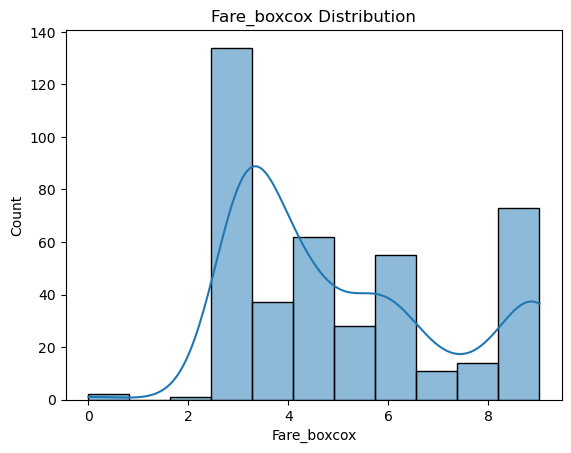

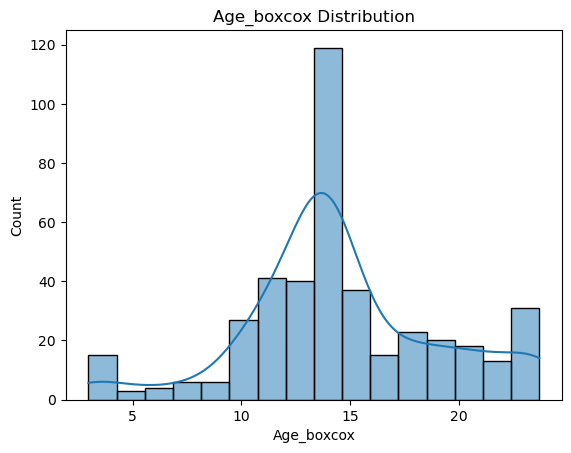

In [22]:
sns.histplot(df['Fare_boxcox'], kde=True)
plt.title("Fare_boxcox Distribution")
plt.show()

sns.histplot(df['Age_boxcox'], kde=True)
plt.title("Age_boxcox Distribution")
plt.show()

In [23]:
# Convert 'Sex' to binary (0 = male, 1 = female)
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Convert 'Embarked' to numeric (One-Hot Encoding)
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

**Load the Model**

In [24]:
xgb_loaded = joblib.load('xgb_final_model999.pkl')


In [25]:
selected_features = joblib.load('xgb_selected_features.pkl')

In [26]:
df = df.iloc[:, selected_features]

In [27]:
y_pred = xgb_loaded.predict(df)

In [28]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [29]:
p = pd.DataFrame(y_pred, columns=['predict999'])

In [30]:
p.to_excel("predict999.xlsx", index=False)